# Prediction of U.S. Corn Future Prices using Machine Learning - Machine Learning

Tables of Contents:
1. Autocorrelation & Stationarity <br>
    1.1 Check for Autocorrelation & Stationarity <br>
    1.2 Differencing <br>
2. Machine Learning <br>
    2.1 Benchmark / SARIMA<br>
    2.2 Linear Regression <br>
    2.3 Support Vector Regressor (SVR) <br>
    2.4 Random Forest <br> 
    2.5 Long Short Term Memory (LSTM) <br>
3. Comparison <br>
4. Feature Selection <br>
    4.1 Optimal Lag Days <br>
    4.2 Feature Importance <br>

In [9]:
# # PACKAGE INSTALLATION:
# import sys

# !{sys.executable} -m pip install tensorflow
# !{sys.executable} -m pip install keras
# !{sys.executable} -m pip install statsmodels
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install xlrd

In [10]:
# Reproducible Results
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

# Importing basic packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, rcParams
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import time
import os
from random import random
from platform import python_version

# Importing packages for machine learning
import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Importing self-written module
%run AA_Functions.ipynb

In [11]:
# Check for up-to-date versions and correct directory
print("Python Version", python_version(), '     | Latest Version 3.8.2 (February 2020)')
print("TensorFlow Version", tf.__version__, ' | Latest Version 2.1.0 (January 2020)')
print("Keras Version", keras.__version__, '      | Latest Version 2.3.1 (October 2019)')
print('Current Directory:', os.getcwd()) # all data and code should be in this directory
warnings.filterwarnings("ignore") # suppress all warnings, can be commented out
style.use('seaborn-whitegrid') # set plot style
rcParams.update({'font.size': 10}) # set plot font size globally

Python Version 3.7.6      | Latest Version 3.8.2 (February 2020)
TensorFlow Version 2.1.0  | Latest Version 2.1.0 (January 2020)
Keras Version 2.3.1       | Latest Version 2.3.1 (October 2019)
Current Directory: C:\Users\nickb\Dropbox\Bachelorarbeit\Bischofberger_Nick_BA\Code


Runtimes for training the algorithms were measured with an Intel Core i7-8565U CPU (single core performance).

## 1. Autocorrelation & Stationarity 

In [12]:
# Read data that has been preprocessed in '01_Preprocessing.ipynb'
df_final = pd.read_csv('Data/Preprocessed_Data/AC_Combined_Model_2001_2018.csv', index_col=0)
df_final

,Price,Yield18,Yield7,AGB18,AGB7,NDVI18,precipitation18,tmax18,tmin18
Date,,,,,,,,,
2001-01-30,209.25,7.260893,7.417578,15.18194,15.83152,0.356333,1.922475,0.998079,-8.752397
2001-01-31,209.00,7.260893,7.417578,15.18194,15.83152,0.355667,2.113111,0.769787,-9.093101
2001-02-01,211.00,7.260893,7.417578,15.18194,15.83152,0.355000,2.081987,0.499550,-9.434367
2001-02-02,213.00,7.260893,7.417578,15.18194,15.83152,0.354200,2.075079,0.391470,-9.658767
2001-02-05,212.00,7.260893,7.417578,15.18194,15.83152,0.351800,2.127651,0.360266,-9.979603
...,...,...,...,...,...,...,...,...,...
2018-12-11,375.00,7.667130,6.798717,15.92238,14.89940,0.411033,1.830614,4.026244,-4.999000
2018-12-12,376.25,7.667130,6.798717,15.92238,14.89940,0.409600,1.846929,3.863437,-5.018503
2018-12-13,375.50,7.667130,6.798717,15.92238,14.89940,0.408167,1.847935,3.641480,-5.123002


### 1.1 Check for Autocorrelation and Stationarity

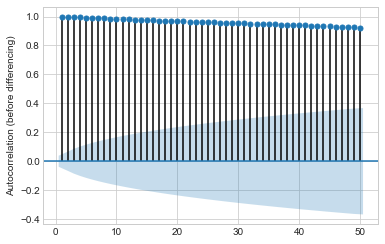

In [13]:
# Get corn price data
df_final.sort_index(inplace=True)
price = df_final['Price'].values
# Create autocorrelation plot for upto 50 lag days
auto_corr = plot_acf(price, alpha=0.01, lags=50, zero=False, title=None)
plt.ylabel('Autocorrelation (before differencing)')
plt.savefig('Graphics/Auto_Corr_Corn_Price.png', dpi=600, bbox_inches='tight')

The autocorrelation plot shows strong autocorrelation. This is a signal for non-stationarity. Let's verify this be conducting an Augmented Dickey-Fuller test...

In [14]:
# Use Augmented Dickey–Fuller test to check stationarity
result = adfuller(price)
print('ADF Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.2f' % (key, value))

ADF Statistic: -1.80
p-value: 0.381583
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57


The null hypothesis H0 of the test is that the time series is non-stationary. Running the example, we can see that the test statistic value is -1.80. This is larger than all of the critical values at the 1%, 5% and 10% confidence levels. So, we can say that the time series does appear to be non-stationary, because the null hypothesis cannot be rejected.

### 1.2 Differencing

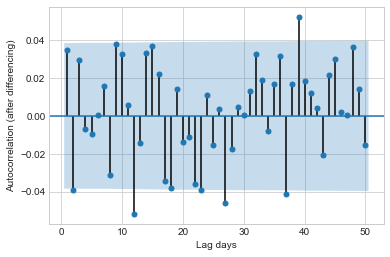

In [15]:
# Difference the dataset
diff = df_final.Price.diff().dropna().values
# Create autocorrelation plot again
plot_acf(diff, alpha=0.01, lags=50, zero=False, title=None)
plt.xlabel('Lag days')
plt.ylabel('Autocorrelation (after differencing)')
plt.savefig('Graphics/Auto_Corr_Corn_Price_Diff.png', dpi=600, bbox_inches='tight')

The autocorrelation plot does not show autocorrelation signs after differencing. This is a signal for a stationary time series. Let's verify this be conducting an Augmented Dickey-Fuller test...

In [16]:
# Use Augmented Dickey–Fuller test to check stationarity
result = adfuller(diff)
print('ADF Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.2f' % (key, value))

ADF Statistic: -14.44
p-value: 0.000000
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57


The null hypothesis of the test is that the time series is non-stationary. Running the example, we can see that the test statistic value after take the first difference was -14.44. This is smaller than all of the critical values at the 1%, 5% and 10% confidence levels. Therefore, we can say that the time series does appear to be stationary, because the null hypothesis could be rejected.

## 2. Machine-/ Deep Learning

In this section we'll try out different machine learning algorithms. <br>
Here they are in order of increasing complexity: <br>
1. SARIMA
2. Linear Regression
3. Support Vector Regressor (SVR)
4. Random Forest Regressor
5. Long Short Term Memory (LSTM)

### 2.1 Benchmark / SARIMA

Seasonal Autoregressive Integrated Moving Average (SARIMA) <br>
Seasional: Repeating pattern within a year that happens over and over again. <br>
Autoregressive: Predict values of time series today based on the value of the time series some period in the past. <br>
Integrated: Time Series has trend that has to be eliminated. <br>
Moving Average: Using moving average of residuals from prior time steps to make forecasts. <br>

In [17]:
# Load dataset and extract corn price values
df = read_dataframe('Data/Preprocessed_Data/AC_Combined_Model_2001_2018.csv')
n_features = 8
n_test = len(df)- df.index.get_loc('2014-01-02') # define test set size
forecast_period = 30
df_price = df[['Price']] # extract corn prices
train, test = df_price[:-n_test], df_price[-n_test:] # split dataset into train & test

In [18]:
# Obs. per year to find seasonal cycle parameter 
print('Total Samples:',len(df))
print('Avg. Samples per year:', int(len(df)/18))

Total Samples: 4503
Avg. Samples per year: 250


The seasonal patterns are expected to repeat annually, i.e. every 250 trading days. Thus, the seasonal parameter "s" is chosen as 250.

In [19]:
# fit SARIMA model
start_time = time.time()
model = SARIMAX(df_price, order=(1, 1, 1), seasonal_order=(1, 0, 1, 250), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
print('--- {:.0f} total seconds ---'.format(time.time() - start_time))

--- 867 total seconds ---


In [20]:
# make SARIMA predictions for whole dataset
yhat = model_fit.predict(start=train.index[0], end=test.index[-1])
df_yhat = pd.DataFrame(yhat[1:])
#df_yhat # for debugging

In [21]:
# calculate forecast error for 30 forecast periods with walk-forward validation
RMSE_sar = list()
MAE_sar = list()
R2_sar = list()
for i in range(0,30):
    # select forecasts and shift them for walk-forward validation 
    sarima = df_yhat[-n_test:].shift(i)
    sarima.dropna(inplace=True)
    test_sarima = df['Price'][-n_test:].iloc[i:]
    # calculate metrics and append to list
    rmse_sar = sqrt(mean_squared_error(test_sarima, sarima))
    mae_score_sar = mean_absolute_error(test_sarima, sarima)
    R2_score_sar = 1-(1-r2_score(test_sarima,sarima))*(len(sarima)-1)/(len(sarima)-n_features-1)
    RMSE_sar.append(rmse_sar)
    MAE_sar.append(mae_score_sar)
    R2_sar.append(R2_score_sar)
    print('t+%d  RMSE:%.2f,  MAE:%.2f,  R2:%.4f' % (i+1, rmse_sar, mae_score_sar, R2_score_sar))

t+1  RMSE:5.23,  MAE:3.92,  R2:0.9798
t+2  RMSE:7.37,  MAE:5.51,  R2:0.9599
t+3  RMSE:8.88,  MAE:6.66,  R2:0.9418
t+4  RMSE:10.24,  MAE:7.78,  R2:0.9224
t+5  RMSE:11.48,  MAE:8.75,  R2:0.9024
t+6  RMSE:12.65,  MAE:9.63,  R2:0.8815
t+7  RMSE:13.68,  MAE:10.32,  R2:0.8615
t+8  RMSE:14.59,  MAE:10.93,  R2:0.8422
t+9  RMSE:15.50,  MAE:11.53,  R2:0.8216
t+10  RMSE:16.42,  MAE:12.21,  R2:0.7996
t+11  RMSE:17.42,  MAE:12.82,  R2:0.7745
t+12  RMSE:18.37,  MAE:13.45,  R2:0.7489
t+13  RMSE:19.24,  MAE:14.09,  R2:0.7243
t+14  RMSE:20.03,  MAE:14.64,  R2:0.7011
t+15  RMSE:20.77,  MAE:15.18,  R2:0.6783
t+16  RMSE:21.49,  MAE:15.69,  R2:0.6555
t+17  RMSE:22.16,  MAE:16.22,  R2:0.6333
t+18  RMSE:22.84,  MAE:16.76,  R2:0.6100
t+19  RMSE:23.47,  MAE:17.18,  R2:0.5876
t+20  RMSE:24.10,  MAE:17.72,  R2:0.5648
t+21  RMSE:24.76,  MAE:18.30,  R2:0.5401
t+22  RMSE:25.42,  MAE:18.77,  R2:0.5144
t+23  RMSE:26.00,  MAE:19.21,  R2:0.4913
t+24  RMSE:26.53,  MAE:19.61,  R2:0.4693
t+25  RMSE:27.05,  MAE:20.04,  R2:

In [22]:
# Create models/datasets for further use with ML algorithms
df_sa = df[1:] # drop first observations, because SARIMA can't predict them
df_sa['SARIMA_pred'] = df_yhat.values # add SARIMA predictions to whole dataset
# Combined Model (see section Forecast Evaluation in thesis)
df_Combined = df_sa
# CGM output model
df_CGM = df_sa.drop({'precipitation18', 'tmax18', 'tmin18'}, axis=1)
# Separate model with climate variables
df_Separate = df_sa.drop({'Yield18', 'Yield7', 'AGB7', 'AGB18'}, axis=1)

#### WASDE release dates

We want to check how well the price predictions for the WASDE release dates are.

In [23]:
# Importing price data with dates as index
df_C1 = read_dataframe('Data/01_Corn_Futures_Price_C1_1999_2019.csv')
df_corn = df_C1[['PX_Last']] # Extract closing price

In [24]:
# Drop NaN values in PX_Last column: 24 missing values are dropped
print('Missing values BEFORE dropping NaN:', df_corn['PX_Last'].isnull().sum())
df_corn.dropna(inplace=True) 
print('Missing values AFTER dropping NaN:', df_corn['PX_Last'].isnull().sum())
print('Count of closing price data:', df_corn.shape[0])

Missing values BEFORE dropping NaN: 24
Missing values AFTER dropping NaN: 0
Count of closing price data: 5247


In [25]:
# Import WASDE release dates
release_dates = pd.read_excel('Data/AB_WASDE_Release_Dates_2001_2018.xlsx', header=0)
release_dates = pd.DataFrame(release_dates['Date'].sort_values(ascending=True))
release_dates['Date'] = pd.to_datetime(release_dates.Date)
release = release_dates.set_index('Date')
# Shift corn price to get presistence model forecasts
df_shifted = df_corn.shift(1)

In [26]:
# Merge WASDE release dates with presistence model (EMH) and SARIMA predictions
df_yhat.rename(columns={0:'SARIMA'}, inplace=True)
price_at_release = pd.merge(df_corn, release, how='inner', on='Date')
prices = pd.merge(price_at_release, df_yhat, how='inner', on='Date')
prices = pd.merge(prices, df_shifted, how='inner', on='Date')
prices.rename(columns={'PX_Last_x':'Observed', 'PX_Last_y':'EMH'}, inplace=True)

In [27]:
prices # for debugging

,Observed,SARIMA,EMH
Date,,,
2001-02-08,210.00,213.233745,212.25
2001-03-08,213.50,215.414107,213.25
2001-04-10,209.00,210.356436,210.75
2001-05-10,191.50,197.749859,197.75
2001-06-12,197.25,197.569532,198.75
...,...,...,...
2018-08-10,357.75,369.025040,369.25
2018-09-12,341.50,355.220264,355.25
2018-10-11,369.25,362.563186,362.75


In [28]:
# Forecast errors for WASDE release dates
rmse = sqrt(mean_squared_error(prices['Observed'], prices['SARIMA']))
mae_score = mean_absolute_error(prices['Observed'], prices['SARIMA'])
R2_score = 1-(1-r2_score(prices['Observed'],
                         prices['SARIMA']))*(len(prices)-1)/(len(prices)-n_features-1)
print('RMSE: {0:.2f},  MAE: {1:.2f},  R2: {2:.4f}'.format(rmse, mae_score, R2_score))

RMSE: 10.15,  MAE: 7.14,  R2: 0.9957


Plot the observed prices onto the SARIMA price predictions for the WASDE release dates for every year.

In [29]:
#-----------------------------------------------------------------
# PARAMETER SELECTION
wasde_year = 2001 # possible values for plotting: year 2001 up to 2018
#-----------------------------------------------------------------

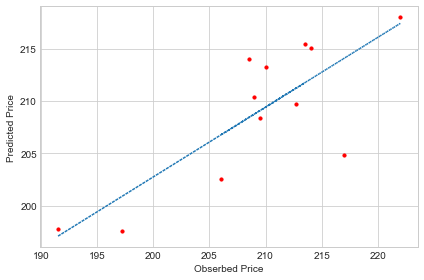

Trend line: y = 69.37 + 0.67*x


In [30]:
# plot observed prices vs. SARIMA predictions
year = wasde_year - 2001
plt.scatter(prices['Observed'][12*year:(year+1)*12], prices['SARIMA'][12*year:(year+1)*12], color='r', label='Price', s=10)
# calc the trendline
z = np.polyfit(prices['Observed'][12*year:(year+1)*12], prices['SARIMA'][12*year:(year+1)*12], 1)
p = np.poly1d(z)
plt.plot(prices['Observed'][12*year:(year+1)*12],p(prices['Observed'][12*year:(year+1)*12]),linestyle=':', label='Trend')
# Add title and axis names
plt.xlabel('Obserbed Price')
plt.ylabel('Predicted Price')
plt.tight_layout()
plt.show()
# the line equation:
print("Trend line: y = %.2f + %.2f*x" % (z[1],z[0]))

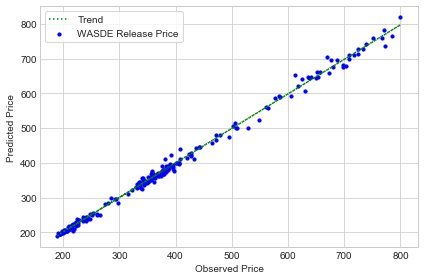

Trend line: y = 2.29 + 0.99*x


In [31]:
# Quantile plot SARIMA forecasts against actual prices to check for outliers
plt.scatter(prices['Observed'], prices['SARIMA'], color='b', label='WASDE Release Price',s=10)
# calc the trendline
z = np.polyfit(prices['Observed'], prices['SARIMA'], 1)
p = np.poly1d(z)
plt.plot(prices['Observed'],p(prices['Observed']), color='g',linestyle=':', label='Trend')
# Add title and axis names
plt.xlabel('Observed Price')
plt.ylabel('Predicted Price')
plt.legend(frameon=True)
plt.tight_layout()
plt.show()
print("Trend line: y = %.2f + %.2f*x" % (z[1],z[0]))

### 2.2 Linear Regression

In [32]:
#-----------------------------------------------------------------
# PARAMETER SELECTION
df = df_Combined # possible values: df_Combined, df_CGM, df_Separate
n_features = 9 # if df_Combined: 9, if df_CGM: 6, if df_Separate: 5
forecast_period = 30 # Number of forecast days
lag_days = 45 # Number of lagged days that should be in the evaluated data set
print('Total number of input features in reframed:', lag_days*n_features)
#-----------------------------------------------------------------

Total number of input features in reframed: 405


In [33]:
# Data preparation
n_test = len(df)- df.index.get_loc('2014-01-02')
scaler, train, test, reframed = prepare_data(df, n_test, n_features, lag_days, forecast_period)
print('Training size:', len(train))
print('Test size:', len(test))
X_train, y_train = train[:, :-forecast_period], train[:, -forecast_period:]
X_test, y_test = test[:, :-forecast_period], test[:, -forecast_period:]

Training size: 3178
Test size: 1249


In [34]:
reframed.columns # for debugging

Index(['var2(t-45)', 'var3(t-45)', 'var4(t-45)', 'var5(t-45)', 'var6(t-45)',
       'var7(t-45)', 'var8(t-45)', 'var9(t-45)', 'var10(t-45)', 'var2(t-44)',
       ...
       'var1(t+20)', 'var1(t+21)', 'var1(t+22)', 'var1(t+23)', 'var1(t+24)',
       'var1(t+25)', 'var1(t+26)', 'var1(t+27)', 'var1(t+28)', 'var1(t+29)'],
      dtype='object', length=435)

In [35]:
# fit linear regression
model = LinearRegression(normalize=False)
model = model.fit(X_train, y_train)

In [36]:
# Make predictions and evaluate them
forecasts = model.predict(X_test) # Prediction from algorithm
actual = [row[-forecast_period:] for row in test] # Acutal test values
# Undifferencing, unscaling and evaluating Prediction vs. Actual
rmse_pred_lin, R2_pred_lin, mae_pred_lin, forecasts_inv, actual_inv = evaluation_RMSE(df, 
        actual, forecasts, train, test, scaler, n_test, lag_days, forecast_period, n_features)
for i in range(len(rmse_pred_lin)):
    print('t+{0:.0f},  RMSE: {1:.2f},  MAE: {3:.2f},  R2: {2:.4f}'
          .format(i+1, rmse_pred_lin[i], R2_pred_lin[i], mae_pred_lin[i]))

t+1,  RMSE: 6.38,  MAE: 4.87,  R2: 0.9710
t+2,  RMSE: 9.02,  MAE: 6.94,  R2: 0.9420
t+3,  RMSE: 10.75,  MAE: 8.21,  R2: 0.9177
t+4,  RMSE: 12.30,  MAE: 9.51,  R2: 0.8921
t+5,  RMSE: 13.57,  MAE: 10.55,  R2: 0.8685
t+6,  RMSE: 14.60,  MAE: 11.46,  R2: 0.8475
t+7,  RMSE: 15.59,  MAE: 12.19,  R2: 0.8259
t+8,  RMSE: 16.57,  MAE: 12.89,  R2: 0.8032
t+9,  RMSE: 17.49,  MAE: 13.68,  R2: 0.7807
t+10,  RMSE: 18.55,  MAE: 14.50,  R2: 0.7529
t+11,  RMSE: 19.66,  MAE: 15.25,  R2: 0.7223
t+12,  RMSE: 20.53,  MAE: 15.91,  R2: 0.6968
t+13,  RMSE: 21.26,  MAE: 16.38,  R2: 0.6744
t+14,  RMSE: 21.93,  MAE: 16.82,  R2: 0.6531
t+15,  RMSE: 22.57,  MAE: 17.29,  R2: 0.6320
t+16,  RMSE: 23.26,  MAE: 17.81,  R2: 0.6088
t+17,  RMSE: 24.00,  MAE: 18.31,  R2: 0.5828
t+18,  RMSE: 24.75,  MAE: 18.85,  R2: 0.5559
t+19,  RMSE: 25.32,  MAE: 19.30,  R2: 0.5345
t+20,  RMSE: 25.92,  MAE: 19.91,  R2: 0.5115
t+21,  RMSE: 26.57,  MAE: 20.52,  R2: 0.4859
t+22,  RMSE: 27.09,  MAE: 21.05,  R2: 0.4648
t+23,  RMSE: 27.50,  MAE:

### 2.3 Support Vector Regressor (SVR)

Important: SVR & Random Forest Regressor only work for forecast_period=1

In [37]:
#-----------------------------------------------------------------
# PARAMETER SELECTION
df = df_Combined # possible values: df_Combined, df_CGM, df_Separate
n_features = 9 # if df_Combined: 9, if df_CGM: 6, if df_Separate: 5
forecast_period = 1 # Number of forecast days
lag_days = 45 # Number of lagged days that should be in the evaluated data set
print('Total number of input features in reframed:', lag_days*n_features)
#-----------------------------------------------------------------

Total number of input features in reframed: 405


In [38]:
# Data preparation for algorithm training
n_test = len(df)- df.index.get_loc('2014-01-02')
scaler, train, test, reframed = prepare_data(df, n_test, n_features, lag_days, forecast_period)
print('Training size:', len(train))
print('Test size:', len(test))
X_train, y_train = train[:, :-forecast_period], train[:, -forecast_period:]
X_test, y_test = test[:, :-forecast_period], test[:, -forecast_period:]

Training size: 3207
Test size: 1249


In [39]:
reframed.columns # for debugging

Index(['var2(t-45)', 'var3(t-45)', 'var4(t-45)', 'var5(t-45)', 'var6(t-45)',
       'var7(t-45)', 'var8(t-45)', 'var9(t-45)', 'var10(t-45)', 'var2(t-44)',
       ...
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var1(t)'],
      dtype='object', length=406)

In [40]:
# Train the SVR algorithm using GridSearch with Cross Validation for hyperparameter tuning.
# Chosen hyperparameters are already optimized
start_time = time.time()
pipe_rf = Pipeline([('regressor', SVR(kernel='rbf'))])

param_grid = {'regressor__C':     [50],
              'regressor__gamma': [5]}

kFold = KFold(n_splits=5, random_state=0)
grid = GridSearchCV(pipe_rf, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, 
                    cv=kFold, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

print('Best MSE Training score: {:.6f}'.format(abs(grid.best_score_)))
print('Best parameters: {}'.format(grid.best_params_))
print('\n', '--- {:.0f} total seconds ---'.format(time.time() - start_time))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Best MSE Training score: 0.001967
Best parameters: {'regressor__C': 50, 'regressor__gamma': 5}

 --- 4 total seconds ---


In [41]:
# Make predictios with SVR for test set
forecasts = grid.best_estimator_.predict(X_test)
actual = [row[-forecast_period:] for row in test]
# Undifferencing, unscaling for predicted & actual prices
rmse_pred, R2_pred, mae_pred, forecasts_inv, actual_inv = evaluation_RMSE(df, actual, forecasts,
                            train, test, scaler, n_test, lag_days, forecast_period, n_features)
forecasts_svr = [item for sublist in forecasts_inv for item in sublist]
actual_svr = [item for sublist in actual_inv for item in sublist]
df_yhat = pd.DataFrame(forecasts_svr, columns={'SVR'})
df_yhat['Observed'] = pd.DataFrame(actual_svr)

In [42]:
# Evaluate predictions with walk-forward approach
RMSE_svr = list()
MAE_svr = list()
R2_svr = list()
for i in range(0,30):
    svr = df_yhat['SVR'].shift(i).dropna()
    test_svr = df_yhat['Observed'].iloc[i:]
    rmse_svr = sqrt(mean_squared_error(test_svr, svr))
    mae_score_svr = mean_absolute_error(test_svr, svr)
    R2_score_svr = R2_score = 1-(1-r2_score(test_svr,svr))*(len(svr)-1)/(len(svr)-n_features-1)
    RMSE_svr.append(rmse_svr)
    MAE_svr.append(mae_score_svr)
    R2_svr.append(R2_score_svr)
    print('t+%d  RMSE:%.2f,  MAE:%.2f,  R2:%.4f' % (i+1, rmse_svr, mae_score_svr, R2_score_svr))

t+1  RMSE:5.51,  MAE:4.22,  R2:0.9776
t+2  RMSE:7.55,  MAE:5.72,  R2:0.9579
t+3  RMSE:9.02,  MAE:6.86,  R2:0.9398
t+4  RMSE:10.36,  MAE:7.93,  R2:0.9205
t+5  RMSE:11.59,  MAE:8.92,  R2:0.9006
t+6  RMSE:12.74,  MAE:9.78,  R2:0.8797
t+7  RMSE:13.75,  MAE:10.44,  R2:0.8599
t+8  RMSE:14.66,  MAE:11.06,  R2:0.8407
t+9  RMSE:15.56,  MAE:11.65,  R2:0.8202
t+10  RMSE:16.47,  MAE:12.32,  R2:0.7982
t+11  RMSE:17.46,  MAE:12.92,  R2:0.7731
t+12  RMSE:18.41,  MAE:13.56,  R2:0.7477
t+13  RMSE:19.27,  MAE:14.21,  R2:0.7233
t+14  RMSE:20.05,  MAE:14.76,  R2:0.7003
t+15  RMSE:20.79,  MAE:15.33,  R2:0.6775
t+16  RMSE:21.49,  MAE:15.84,  R2:0.6549
t+17  RMSE:22.16,  MAE:16.39,  R2:0.6328
t+18  RMSE:22.83,  MAE:16.91,  R2:0.6098
t+19  RMSE:23.46,  MAE:17.37,  R2:0.5875
t+20  RMSE:24.09,  MAE:17.90,  R2:0.5647
t+21  RMSE:24.75,  MAE:18.45,  R2:0.5401
t+22  RMSE:25.41,  MAE:18.94,  R2:0.5145
t+23  RMSE:25.98,  MAE:19.38,  R2:0.4918
t+24  RMSE:26.51,  MAE:19.79,  R2:0.4698
t+25  RMSE:27.02,  MAE:20.23,  R2:

### 2.4 Random Forest

In [43]:
# Train the RF algorithm using GridSearch with Cross Validation for hyperparameter tuning.
# Chosen hyperparameters are already optimized
start_time = time.time()
pipe_rf = Pipeline([('regressor', RandomForestRegressor(criterion='mse', random_state=1,
                                                        n_jobs=-1))])

param_grid = {'regressor__n_estimators':      [1000],   # higher is better 
              'regressor__max_features':      ['sqrt'], 
              'regressor__min_samples_leaf':  [20],     
              'regressor__min_samples_split': [10]}     

kFold = KFold(n_splits=5, random_state=0)
grid = GridSearchCV(pipe_rf, param_grid, scoring='neg_mean_squared_error', n_jobs=-1,
                    cv=kFold, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

print('Best MSE Training score: {:.6f}'.format(abs(grid.best_score_)))
print('Best parameters: {}'.format(grid.best_params_))
print('\n', '--- {:.0f} total seconds ---'.format(time.time() - start_time))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   34.6s remaining:   52.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.3s finished


Best MSE Training score: 0.001873
Best parameters: {'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 20, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 1000}

 --- 45 total seconds ---


In [44]:
# Make predictions with Random Forest for test set
forecasts = grid.best_estimator_.predict(X_test)
actual = [row[-forecast_period:] for row in test]
# Undifferencing, unscaling for predicted & actual prices
rmse_rf, R2_rf, mae_rf, forecasts_inv, actual_inv = evaluation_RMSE(df, actual, forecasts, 
                        train, test, scaler, n_test, lag_days, forecast_period, n_features)
forecasts_rf = [item for sublist in forecasts_inv for item in sublist]
actual_rf = [item for sublist in actual_inv for item in sublist]
df_yhat = pd.DataFrame(forecasts_rf, columns={'RF'})
df_yhat['Observed'] = pd.DataFrame(actual_rf)

In [45]:
# Evaluate predictions with walk-forward approach
RMSE_rf = list()
MAE_rf = list()
R2_rf = list()
for i in range(0,30):
    rf = df_yhat['RF'].shift(i).dropna()
    test_rf = df_yhat['Observed'].iloc[i:]
    rmse_rf = sqrt(mean_squared_error(test_rf, rf))
    mae_score_rf = mean_absolute_error(test_rf, rf)
    R2_score_rf = R2_score = 1-(1-r2_score(test_rf,rf))*(len(rf)-1)/(len(rf)-n_features-1)
    RMSE_rf.append(rmse_rf)
    MAE_rf.append(mae_score_rf)
    R2_rf.append(R2_score_rf)
    print('t+%d  RMSE:%.2f,  MAE:%.2f,  R2:%.4f' % (i+1, rmse_rf, mae_score_rf, R2_score_rf))

t+1  RMSE:5.23,  MAE:3.93,  R2:0.9798
t+2  RMSE:7.32,  MAE:5.48,  R2:0.9604
t+3  RMSE:8.81,  MAE:6.63,  R2:0.9426
t+4  RMSE:10.18,  MAE:7.74,  R2:0.9233
t+5  RMSE:11.41,  MAE:8.70,  R2:0.9036
t+6  RMSE:12.56,  MAE:9.56,  R2:0.8831
t+7  RMSE:13.57,  MAE:10.24,  R2:0.8635
t+8  RMSE:14.49,  MAE:10.86,  R2:0.8442
t+9  RMSE:15.40,  MAE:11.47,  R2:0.8239
t+10  RMSE:16.32,  MAE:12.13,  R2:0.8020
t+11  RMSE:17.31,  MAE:12.74,  R2:0.7770
t+12  RMSE:18.26,  MAE:13.36,  R2:0.7518
t+13  RMSE:19.12,  MAE:14.01,  R2:0.7275
t+14  RMSE:19.91,  MAE:14.53,  R2:0.7046
t+15  RMSE:20.66,  MAE:15.09,  R2:0.6817
t+16  RMSE:21.37,  MAE:15.61,  R2:0.6590
t+17  RMSE:22.04,  MAE:16.13,  R2:0.6369
t+18  RMSE:22.72,  MAE:16.66,  R2:0.6137
t+19  RMSE:23.35,  MAE:17.08,  R2:0.5915
t+20  RMSE:23.99,  MAE:17.64,  R2:0.5685
t+21  RMSE:24.65,  MAE:18.21,  R2:0.5438
t+22  RMSE:25.31,  MAE:18.68,  R2:0.5184
t+23  RMSE:25.88,  MAE:19.12,  R2:0.4956
t+24  RMSE:26.42,  MAE:19.53,  R2:0.4735
t+25  RMSE:26.94,  MAE:19.96,  R2:

### 2.5 Long Short Term Memory (LSTM)

In [46]:
#-----------------------------------------------------------------
# PARAMETER SELECTION
df = df_Combined # possible values: df_Combined, df_CGM, df_Separate
n_features = 9 # if df_Combined: 9, if df_CGM: 6, if df_Separate: 5
forecast_period = 30 # Number of forecast days
lag_days = 45 # Number of lagged days that should be in the evaluated data set
# LSTM params (chosen hyperparameters are optimized as best as possible):
n_epochs = 20 # Number of epochs for training
n_batch = 1 # Number of batches for training dataset
n_neurons = 1 # Number of LSMT units/cells per hidden layer
learning_rate = 0.000015 # fixed at 0.000015
print('Total number of input features in reframed:', lag_days*n_features)
#-----------------------------------------------------------------

Total number of input features in reframed: 405


In [47]:
# Debugging summary values and automatic parameter creation
n_test = len(df)- df.index.get_loc('2014-01-02')
n_obs = lag_days * n_features # Number of variables taking all lag_days into account
n_var_in_model = lag_days * n_features + forecast_period
total_obs = len(df) - (lag_days-1) - (forecast_period-1) - 2
training_size = total_obs - n_test # Number of training set size = whole dataset - n_test
print('Total samples from 2001-2018:', total_obs)
print('Samples in test set:', n_test)
print('Number of features in reframed model:', n_var_in_model) # for debugging

Total samples from 2001-2018: 4427
Samples in test set: 1249
Number of features in reframed model: 435


In [48]:
# Data preparation for algorithm training
scaler, train, test, reframed = prepare_data(df, n_test, n_features, lag_days, forecast_period)
print(train.shape[0] == training_size) # for debugging, value has to be 'True'
print(reframed.shape[0] == total_obs) # for debugging, value has to be 'True'

True
True


In [49]:
reframed.columns # for debugging

Index(['var2(t-45)', 'var3(t-45)', 'var4(t-45)', 'var5(t-45)', 'var6(t-45)',
       'var7(t-45)', 'var8(t-45)', 'var9(t-45)', 'var10(t-45)', 'var2(t-44)',
       ...
       'var1(t+20)', 'var1(t+21)', 'var1(t+22)', 'var1(t+23)', 'var1(t+24)',
       'var1(t+25)', 'var1(t+26)', 'var1(t+27)', 'var1(t+28)', 'var1(t+29)'],
      dtype='object', length=435)

In [50]:
# Training and fitting the LSTM algorithm
start_time = time.time()
model, model_fit = fit_lstm(train, lag_days, forecast_period, n_batch, n_epochs, n_neurons, 
                            n_features, learning_rate)
print('\n', '--- {:.0f} total seconds ---'.format(time.time() - start_time))

Epoch 1/20
3178/3178 [==============================] - 69s 22ms/step - loss: 0.5455
Epoch 2/20
3178/3178 [==============================] - 68s 22ms/step - loss: 0.4202
Epoch 3/20
3178/3178 [==============================] - 67s 21ms/step - loss: 0.3066
Epoch 4/20
3178/3178 [==============================] - 67s 21ms/step - loss: 0.2159
Epoch 5/20
3178/3178 [==============================] - 67s 21ms/step - loss: 0.1449
Epoch 6/20
3178/3178 [==============================] - 70s 22ms/step - loss: 0.0916
Epoch 7/20
3178/3178 [==============================] - 68s 21ms/step - loss: 0.0542 
Epoch 8/20
3178/3178 [==============================] - 68s 21ms/step - loss: 0.0297
Epoch 9/20
3178/3178 [==============================] - 68s 21ms/step - loss: 0.0152
Epoch 10/20
3178/3178 [==============================] - 68s 22ms/step - loss: 0.0075
Epoch 11/20
3178/3178 [==============================] - 71s 22ms/step - loss: 0.0039
Epoch 12/20
3178/3178 [==============================] - 70s 2

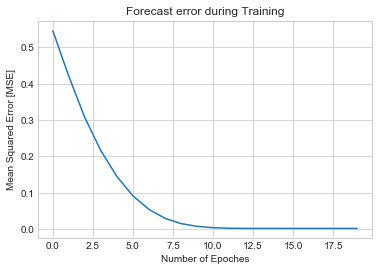

In [51]:
# plot training score history
plt.plot(model_fit.history['loss'], label='Train MSE')
plt.title('Forecast error during Training')
plt.xlabel('Number of Epoches')
plt.ylabel('Mean Squared Error [MSE]')
plt.show()

In [52]:
# Make predictions with LSTM for test set
forecasts = make_forecasts(model, n_batch, train, test, lag_days, forecast_period, n_features)
actual = [row[-forecast_period:] for row in test]
# Undifferencing, unscaling for predicted & actual prices
rmse_pred, R2_pred, mae_pred, forecasts_inv, actual_inv = evaluation_RMSE(df, actual, forecasts,
                            train, test, scaler, n_test, lag_days, forecast_period, n_features)
for i in range(len(rmse_pred)):
    print('t+{0:.0f}  RMSE: {1:.2f},  MAE: {3:.2f},  R2: {2:.4f}'
          .format(i+1, rmse_pred[i], R2_pred[i], mae_pred[i]))

t+1  RMSE: 5.24,  MAE: 3.94,  R2: 0.9804
t+2  RMSE: 7.37,  MAE: 5.53,  R2: 0.9613
t+3  RMSE: 8.90,  MAE: 6.71,  R2: 0.9436
t+4  RMSE: 10.27,  MAE: 7.83,  R2: 0.9247
t+5  RMSE: 11.51,  MAE: 8.78,  R2: 0.9053
t+6  RMSE: 12.65,  MAE: 9.61,  R2: 0.8855
t+7  RMSE: 13.67,  MAE: 10.28,  R2: 0.8661
t+8  RMSE: 14.59,  MAE: 10.87,  R2: 0.8474
t+9  RMSE: 15.51,  MAE: 11.50,  R2: 0.8275
t+10  RMSE: 16.45,  MAE: 12.19,  R2: 0.8058
t+11  RMSE: 17.43,  MAE: 12.78,  R2: 0.7816
t+12  RMSE: 18.40,  MAE: 13.40,  R2: 0.7563
t+13  RMSE: 19.29,  MAE: 14.08,  R2: 0.7319
t+14  RMSE: 20.09,  MAE: 14.64,  R2: 0.7090
t+15  RMSE: 20.86,  MAE: 15.19,  R2: 0.6857
t+16  RMSE: 21.58,  MAE: 15.73,  R2: 0.6632
t+17  RMSE: 22.29,  MAE: 16.31,  R2: 0.6403
t+18  RMSE: 23.00,  MAE: 16.89,  R2: 0.6163
t+19  RMSE: 23.65,  MAE: 17.32,  R2: 0.5938
t+20  RMSE: 24.30,  MAE: 17.85,  R2: 0.5708
t+21  RMSE: 24.97,  MAE: 18.43,  R2: 0.5461
t+22  RMSE: 25.64,  MAE: 18.89,  R2: 0.5208
t+23  RMSE: 26.20,  MAE: 19.36,  R2: 0.4987
t+24  

#### 2.5.1 WASDE Release Dates

We want to check how well the price predictions for the WASDE release dates are.

In [53]:
# Extract 1-day forecasts for plotting,...
forecasts = []
for sublist in forecasts_inv:
    forecasts.append(sublist[0])
forecasts = np.array(forecasts)
# ...extract actual prices for plotting,...
actual = []
for sublist in actual_inv:
    actual.append(sublist[0])
actual = np.array(actual)
residuals = [actual[i]-forecasts[i] for i in range(len(forecasts))]
residuals = np.array(residuals)
# ...extract forecasting dates and put all those variables in one dataframe.
df_forecasts = pd.DataFrame(forecasts)
df_forecasts['Date'] = pd.DataFrame(df[-n_test-forecast_period+1:-forecast_period+1].index)
df_forecasts.set_index('Date', inplace=True)
df_forecasts.rename(columns={0:'LSTM'}, inplace=True)
df_forecasts['Observed'] = pd.DataFrame(actual).values

In [54]:
# Merge WASDE release dates with LSTM forecasts
prices = pd.merge(price_at_release, df_forecasts, how='inner', on='Date')
# Calculate forecast error for WASDE release dates
rmse = sqrt(mean_squared_error(prices['Observed'], prices['LSTM']))
mae_score = mean_absolute_error(prices['Observed'], prices['LSTM'])
R2_score = 1-(1-r2_score(prices['Observed'], 
                         prices['LSTM']))*(len(forecasts)-1)/(len(forecasts)-n_features-1)
print('RMSE: {0:.2f},  MAE: {1:.2f},  R2: {2:.4f}'.format(rmse, mae_score, R2_score))

RMSE: 7.42,  MAE: 5.49,  R2: 0.9634


Trend line: y = 2.29 + 0.99*x


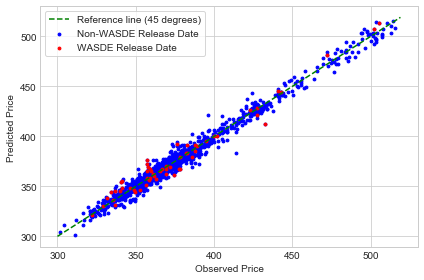

In [55]:
# Plot observed and predicted prices for WASDE release dates and non-WASDE release dates
plt.scatter(actual, forecasts, color='b', label='Non-WASDE Release Date', s=8)
plt.scatter(prices['Observed'], prices['LSTM'], label='WASDE Release Date', s=8, color='r')
# plot 45 degree reference line
plt.plot(range(300,520), range(300,520), label='Reference line (45 degrees)', color='g', linestyle='--')
plt.xlabel('Observed Price')
plt.ylabel('Predicted Price')
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig('Graphics/Quantile_Plot.png', dpi=600, bbox_inches='tight')
print("Trend line: y = %.2f + %.2f*x" % (z[1],z[0]))

We want to check if there is any seasonality or trend present in the residuals, that suggest that our results are not robust.

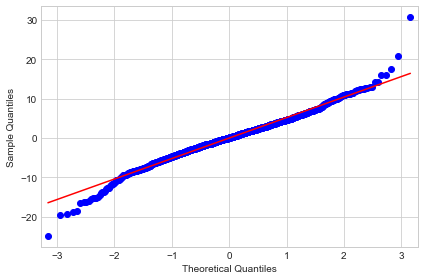

In [56]:
# QQPlot to check if residuals are normally distributed (no seasonality and trend in error)
fig = sm.qqplot(data=residuals, line='r')
plt.tight_layout()
plt.savefig('Graphics/QQPlot_Residuals.png', dpi=600, bbox_inches='tight')

The Quantile-Quantile Plot shows that the distribution is seemingly normal with a few bumps and outliers. Thus, no trend and seasonality can be observed in the residuals.

## 3. Comparison

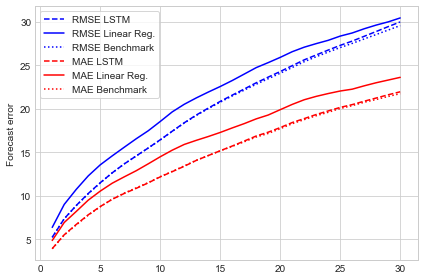

In [57]:
# Compare different algorithms across all forecast periods (Random Forest and SVR results can be commented in)
plt.plot(range(1,31), rmse_pred, label='RMSE LSTM', color='blue', linestyle='--')
plt.plot(range(1,31), rmse_pred_lin, label='RMSE Linear Reg.', color='blue')
plt.plot(range(1,31), RMSE_sar, label='RMSE Benchmark', color='blue', linestyle=':')
# plt.plot(range(1,31), RMSE_rf, label='RMSE Random Forest', color='blue', linestyle='--')
# plt.plot(range(1,31), RMSE_svr, label='RMSE SVR', color='blue', linestyle='-.')
plt.plot(range(1,31), mae_pred, label='MAE LSTM', color='red', linestyle='--')
plt.plot(range(1,31), mae_pred_lin, label='MAE Linear Reg.', color='red')
plt.plot(range(1,31), MAE_sar, label='MAE Benchmark', linestyle=':', color='red')
# plt.plot(range(1,31), MAE_rf, label='MAE Random Forest', linestyle='--', color='red')
# plt.plot(range(1,31), MAE_svr, label='MAE SVR', linestyle='-.', color='red')
plt.ylabel('Forecast error')
#plt.xlabel('Forecast period (days)')
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig('Graphics/RMSE_MAE_30_Forecast.png', dpi=600, bbox_inches='tight')

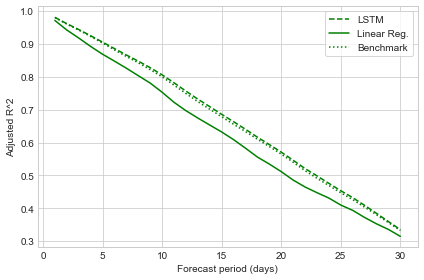

In [58]:
# Compare different algorithms across all forecast periods (Random Forest and SVR results can be commented in)
plt.plot(range(1,31), R2_pred, label='LSTM', color='green', linestyle='--')
plt.plot(range(1,31), R2_pred_lin, label='Linear Reg.', color='green', linestyle='-')
plt.plot(range(1,31), R2_sar, label='Benchmark', color='green', linestyle=':')
# plt.plot(range(1,31), R2_rf, label='Random Forest', linestyle='--', color='green')
# plt.plot(range(1,31), R2_svr, label='SVR', linestyle='-.', color='green')
plt.ylabel('Adjusted R^2')
plt.xlabel('Forecast period (days)')
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig('Graphics/R2_30_Forecast.png', dpi=600, bbox_inches='tight')

## 4. Feature Selection

In [59]:
# Parameter selection
file = 'Data/Preprocessed_Data/AC_Combined_Model_2001_2018.csv'
df = read_dataframe(file)
n_test = len(df)- df.index.get_loc('2014-01-02')
n_features = 8
forecast_period = 1
print('Total number of input features (in reframed):', lag_days*n_features)

Total number of input features (in reframed): 360


### 4.1 Optimal Lag Days

Find optimal number of lag days by runing the Random Forest algorithm for up to 50 lag days (50 lag days * 8 variables = 400 features). Exclusive the SARIMA predictions.

In [60]:
# Parameter selection: lagged days
lag = range(1, 51)

In [61]:
start_time = time.time()
score = list()
for i in lag:
    print('Features selected =', i)
    lag_days = i
    scaler, train, test, reframed = prepare_data(df,n_test,n_features,lag_days,forecast_period)
    X_train, y_train = train[:, :-forecast_period], train[:, -forecast_period:]
    X_test, y_test = test[:, :-forecast_period], test[:, -forecast_period:]
    
    pipe_rf = Pipeline([('regressor', RandomForestRegressor(random_state=5, criterion = 'mse', 
                                                            n_jobs=-1))])
    
    param_grid = {'regressor__n_estimators':      [1000],   
                  'regressor__max_features':      ['sqrt'],
                  'regressor__min_samples_leaf':  [20],     
                  'regressor__min_samples_split': [10]}
    
    kFold = KFold(n_splits=5, random_state=0)
    grid = GridSearchCV(pipe_rf, param_grid, scoring='neg_mean_squared_error', n_jobs=-1,
                        cv=kFold, return_train_score=True)
    grid.fit(X_train, y_train)
    
    # Make predictions with Random Forest algorithm
    forecasts = grid.best_estimator_.predict(X_test)
    actual = [row[-forecast_period:] for row in test]
    # Undifferencing, unscaling for predicted & actual prices
    rmse_pred, R2_pred, mae_pred, forecasts_inv, actual_inv = evaluation_RMSE(df, 
            actual, forecasts, train, test, scaler, n_test, i, forecast_period, n_features)
    score.append(rmse_pred)
print('\n', '--- {:.0f} total seconds ---'.format(time.time() - start_time))
print('--- {:.0f} average seconds per round ---'.format((time.time() - start_time)/lag_days))

Features selected = 1
Features selected = 2
Features selected = 3
Features selected = 4
Features selected = 5
Features selected = 6
Features selected = 7
Features selected = 8
Features selected = 9
Features selected = 10
Features selected = 11
Features selected = 12
Features selected = 13
Features selected = 14
Features selected = 15
Features selected = 16
Features selected = 17
Features selected = 18
Features selected = 19
Features selected = 20
Features selected = 21
Features selected = 22
Features selected = 23
Features selected = 24
Features selected = 25
Features selected = 26
Features selected = 27
Features selected = 28
Features selected = 29
Features selected = 30
Features selected = 31
Features selected = 32
Features selected = 33
Features selected = 34
Features selected = 35
Features selected = 36
Features selected = 37
Features selected = 38
Features selected = 39
Features selected = 40
Features selected = 41
Features selected = 42
Features selected = 43
Features selected = 

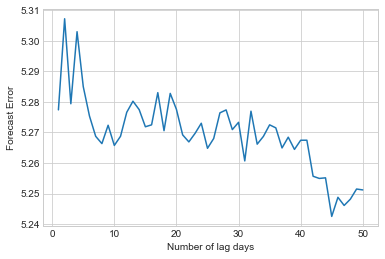

In [62]:
plt.plot(lag, score)
plt.xlabel('Number of lag days')
plt.ylabel('Forecast Error')
plt.savefig('Graphics/Lag_Day_Selection.png',dpi=600, bbox_inches='tight')

Lowest forecast error with 45 lag days. Thus, 45 lag days is used for training the algorithms.

### 4.2 Feature Importance

In [63]:
#-----------------------------------------------------------------
# PARAMETER SELECTION
lag_days = 45
#-----------------------------------------------------------------

In [64]:
scaler, train, test, reframed = prepare_data(df, n_test, n_features, lag_days, forecast_period)
print('Training size:', len(train))
print('Test size:', len(test))
X_train, y_train = train[:, :-forecast_period], train[:, -forecast_period:]
X_test, y_test = test[:, :-forecast_period], test[:, -forecast_period:]

Training size: 3208
Test size: 1249


In [65]:
reframed.columns # for debugging

Index(['var2(t-45)', 'var3(t-45)', 'var4(t-45)', 'var5(t-45)', 'var6(t-45)',
       'var7(t-45)', 'var8(t-45)', 'var9(t-45)', 'var2(t-44)', 'var3(t-44)',
       ...
       'var9(t-2)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var1(t)'],
      dtype='object', length=361)

In [66]:
model = RandomForestRegressor(random_state=1, n_estimators=1000, max_features='sqrt', 
                        min_samples_leaf=20, min_samples_split=10, n_jobs=-1, criterion='mse')
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [67]:
importances = model.feature_importances_
names = reframed.columns.values[:-forecast_period]
important_features = pd.Series(data=importances*100,index=names)
important_features.sort_values(ascending=False,inplace=True)
important_features.head(10)

var7(t-41)    0.822896
var7(t-11)    0.793300
var7(t-4)     0.778990
var7(t-15)    0.769709
var7(t-20)    0.706681
var7(t-38)    0.691060
var7(t-34)    0.688563
var7(t-37)    0.653308
var7(t-1)     0.626176
var7(t-28)    0.615798
dtype: float64

In [68]:
df.head(1)

,Price,Yield18,Yield7,AGB18,AGB7,NDVI18,precipitation18,tmax18,tmin18
Date,,,,,,,,,
2001-01-30,209.25,7.260893,7.417578,15.18194,15.83152,0.356333,1.922475,0.998079,-8.752397


var7 = precipitatio18, thus I looks like without including the SARIMA predictions, the precipitation data is the most influential on the corn price.

### Acknowledgements

Foremost, I would like to express my sincere gratitude to my external supervisors, Benjamin Zimmermann and Dr. sc. Stefanos Mystakidis, for their continuous support during my Bachelor thesis, for their patience, motivation, and immense knowledge about the corn market. Their guidance helped me during the research, coding, and writing of this thesis. I could not have imagined having better supervisors and mentors for this study. <br>
Besides my external supervisors, I wish to extend my special thanks to my colleague Dr. Anastasis Kratsios and my flatmate Victor Staartjes who helped me brainstorm for the machine learning part of my thesis. Their assistance is greatly appreciated.